# Probabilistic Programming 2: Message Passing & Analytical Solutions

#### Goal 
  - Understand when and how analytical solutions to Bayesian inference can be obtained.
  - Understand how to perform message passing in a Forney-style factor graph.

#### Materials        
  - Mandatory
    - This notebook
    - Lecture notes on factor graphs
    - Lecture notes on continuous data
    - Lecture notes on discrete data
  - Optional
    - Chapters 2 and 3 of [Model-Based Machine Learning](http://www.mbmlbook.com/LearningSkills.html).
    - [Differences between Julia and Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

Note that none of the material below is new. The point of the Probabilistic Programming sessions is to solve practical problems so that the concepts from Bert's lectures become less abstract.

In [1]:
using Pkg
Pkg.activate("./workspace/")
Pkg.instantiate();
IJulia.clear_output();

In [2]:
using LinearAlgebra
using SpecialFunctions
using ForneyLab
using PyCall
using Plots
pyplot();

We'll be using the toolbox [ForneyLab.jl](https://github.com/biaslab/ForneyLab.jl) to visualize factor graphs and compute messages passed within the graph.

## Problem: A Job Interview

After you finish your master's degree, you will need to start looking for jobs. You will get one or more job interviews and some will be fun while others will be frustrating. The company you applied at wants a talented and skilled employee, but measuring a person's skill is tricky. Even a highly-skilled person makes mistakes and people with few skills can get lucky. In this session, we will look at various ways to assess skills using questions and test assignments. Along the way, you will gain experience with message passing, factor graphs and working with discrete vs continuous data.

### 1: Right or wrong

Suppose you head to a job interview for a machine learning engineer position. The company is interested in someone who knows Julia and has set up a test with syntax questions. We will first look at a single question, which we treat as an outcome variable $X_1$. You can either get this question right or wrong, which means we're dealing with a Bernoulli likelihood. The company assumes you have a skill level, denoted $\theta$, and the higher the skill, the more likely you are to get the question right. Since the company doesn't know anything about you, they chose an uninformative prior distribution: the Beta(1,1). We can write the generative model for answering this question as follows:

$$\begin{align*}
p(X_1, \theta) =&\ p(X_1 \mid \theta) \cdot p(\theta) \\
=&\ \text{Bernoulli}(X_1 \mid \theta) \cdot \text{Beta}(\theta \mid \alpha = 1, \beta=1) \, .
\end{align*}$$

The factor graph for this model is:

<!-- <img align="left" width=50 src="../figures/ffg-PP2-01.png"> -->
![](../figures/ffg-PP2-01.png)

where $f_b(X_1, \theta) \triangleq \text{Bernoulli}(X_1 \mid \theta)$ and $f_a(\theta) \triangleq \text{Beta}(\theta \mid 1,1)$. We are now going to construct this factor graph using the toolbox ForneyLab.

In [3]:
# Start building a model by setting up a FactorGraph structure
factor_graph1 = FactorGraph()

# Add the prior over 
@RV θ ~ Beta(1.0, 1.0, id=:f_a)

# Add the question correctness likelihood
@RV X1 ~ Bernoulli(θ, id=:f_b)

# The outcome X1 is going to be observed, so we set up a placeholder for the data entry
placeholder(X1, :X1)

# Visualize the graph
ForneyLab.draw(factor_graph1)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3988001907220899712 -->
 
 3988001907220899712 
 
 clamp_2 
 
<!-- 4613013386898860935 -->
 
 4613013386898860935 
 
 Beta 
 f_a 
 
<!-- 4613013386898860935--3988001907220899712 -->
 
 4613013386898860935--3988001907220899712 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 12810901875278578999 -->
 
 12810901875278578999 
 
 clamp_1 
 
<!-- 4613013386898860935--12810901875278578999 -->
 
 4613013386898860935--12810901875278578999 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 8650012718394651541 -->
 
 8650012718394651541 
 
 Ber 
 f_b 
 
<!-- 8650012718394651541--4613013386898860935 -->
 
 8650012718394651541--4613013386898860935 
 
 θ 
 1 out 
 2 p 
 
<!-- 2637909072717122613 -->
 
 2637909072717122613 
 
 placeholder_X1 
 
<!-- 2637909072717122613--8650012718394651541 -->
 
 2637909072717122613--8650012718394651541 
 
 X1 
 1 out 
 1 out

Code notes:
- @RV is a macro that lets you add Random Variables as nodes to your factor graph.
- The symbol ~ means "is distributed as". For example, $\theta \sim \text{Beta}(1,1)$ should be read as "$\theta$ is distributed according to a Beta($\theta$ | $a$=1, $b$=1) probability distribution".

----

Above you can see the factor graph that ForneyLab has generated. It is not as clean as the ones in the theory lectures. For example, ForneyLab generates nodes for the clamped parameters of the Beta prior ($\alpha = 1$ and $\beta = 1$), while we ignore these in the manually constructed graphs. Nonetheless, ForneyLab's version is very useful for debugging later on. 

We are now going to tell ForneyLab to generate a message passing procedure for us.

In [4]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4613013386898860935 -->
 
 4613013386898860935 
 
 Beta 
 f_a 
 
<!-- 3988001907220899712 -->
 
 3988001907220899712 
 
<!-- 4613013386898860935--3988001907220899712 -->
 
 4613013386898860935--3988001907220899712 
 
 1 out 
 3 b 
 
<!-- 12810901875278578999 -->
 
 12810901875278578999 
 
<!-- 4613013386898860935--12810901875278578999 -->
 
 4613013386898860935--12810901875278578999 
 
 1 out 
 2 a 
 
<!-- 8650012718394651541 -->
 
 8650012718394651541 
 
 Ber 
 f_b 
 
<!-- 8650012718394651541--4613013386898860935 -->
 
 8650012718394651541--4613013386898860935 
 
 θ 
 1 out 
 ((1)) 
 2 p 
 ((2)) 
 
<!-- 2637909072717122613 -->
 
 2637909072717122613 
 
<!-- 2637909072717122613--8650012718394651541 -->
 
 2637909072717122613--8650012718394651541 
 
 1 out 
 1 out

Code notes:
- ForneyLab.jl compiles the specified model and inference procedure into a string. This string is human-readable and portable across devices. The functions `eval(Meta.parse())` are used to bring that string into the current scope, so the generated code can be used.
- In `ForneyLab.draw()`, only the edge of interest is shown with the two connecting nodes and their inputs. All other parts of the graph are ignored.

----

ForneyLab's visualization of the message passing procedure for a specific variable isolates that variable in the graph and shows where the incoming messages come from. In this case, we are interested in $\theta$ (your skill level), which receives message ((2)) from the likelihood node (the "Ber" node above $\theta$) and message ((1)) from the prior node (the "Beta" node below $\theta$). 

In the message passing framework, the combination of these two messages produces the "marginal" distribution for $\theta$. We are using message passing to do Bayesian inference, so note that the "marginal" for $\theta$ corresponds to the posterior distribution $p(\theta \mid X_1)$. 

Let's inspect these messages.

In [5]:
# Initialize a message data structure
messages = Array{Message}(undef, 2)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 correct
data = Dict(:X1 => 1)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
println("Message ((2)) = "*string(messages[2].dist))


Message ((1)) = Beta(a=1.00, b=1.00)
Message ((2)) = Beta(a=2.00, b=1.00)



Code notes:
- A `Dict` is a [dictionary data structure](https://docs.julialang.org/en/v1/base/collections/#Base.Dict). In the `marginals` dictionary we only have one entry: the key is the variable `θ` (as a Symbol, i.e. as `:θ`) and the value is a `ProbabilityDistribution` object. It is the initial distribution for that variable. In the `data` dictionary, we also only have one entry: the key is the variable `X1` and the value is a Float. This is because `X1` is observed. We know its value without uncertainty.
- The `stepθ!` function comes from the algorithm compilation.

----

Alright. So, they are both Beta distributions. Do they actually make sense? Where do these parameters come from?

Recall from the lecture notes that the formula for messages sent by factor nodes is:

$$ \boxed{
\underbrace{\overrightarrow{\mu}_{Y}(y)}_{\substack{ \text{outgoing}\\ \text{message}}} = \sum_{x_1,\ldots,x_n} \underbrace{\overrightarrow{\mu}_{X_1}(x_1)\cdots \overrightarrow{\mu}_{X_n}(x_n)}_{\substack{\text{incoming} \\ \text{messages}}} \cdot \underbrace{f(y,x_1,\ldots,x_n)}_{\substack{\text{node}\\ \text{function}}} }
$$

<p style="text-align:center;"><img src="../figures/ffg-sum-product.png" width="500px"></p>

The prior node is not connected to any other unknown variables and so does not receive incoming messages. Its outgoing message is therefore:

$$\begin{align}
\overrightarrow{\mu}(\theta) =&\ f(\theta) \\
=&\ \text{Beta}(\theta \mid 1,1) \, .
\end{align}$$

So that confirms the correctness of Message ((1)).

Similarly, we can also derive the message from the likelihood node by hand. For this, we need to know that the message coming from the observation $\overleftarrow{\mu}(x)$ is a delta function, which, if you gave the right answer ($X_1 = 1$), has the form $\delta(X_1 - 1)$. The "node function" is the Bernoulli likelihood $\text{Bernoulli}(X_1 \mid \theta)$. Another thing to note is that this is essentially a convolution with respect to a delta function and that its [sifting property](https://en.wikipedia.org/wiki/Dirac_delta_function#Translation) holds: $\int_{X_1} \delta(X_1 - x) \ f(X_1, \theta) \mathrm{d}X_1 = f(x, \theta)$. The fact that $X_1$ is a discrete variable instead of a continuous one, does not negate this. Using these facts, we can perform the message computation by hand:

$$\begin{align}
\overleftarrow{\mu}(\theta) =&\ \sum_{X_1} \overleftarrow{\mu}(X_1) \ f(X_1, \theta) \\
=&\ \sum_{X_1} \delta(X_1 - 1) \ \text{Bernoulli}(X_1 \mid \theta) \\
=&\ \sum_{X_1} \delta(X_1 - 1) \ \theta^{X_1} (1 - \theta)^{1-X_1} \\
=&\ \theta^{1} (1 - \theta)^{1-1} \, .
\end{align}$$

Remember that the pdf of a Beta distribution is proportional to $\theta^{\alpha-1} (1 - \theta)^{\beta-1}$. So, if you read the second-to-last line above as $\theta^{2-1} (1 - \theta)^{1-1}$, then the outgoing message $\overleftarrow{\mu}(\theta)$ is proportional to a Beta distribution with $\alpha=2$ and $\beta=1$. So, our manual derivation verifies ForneyLab's Message ((2)).

Let's now look at these messages visually.

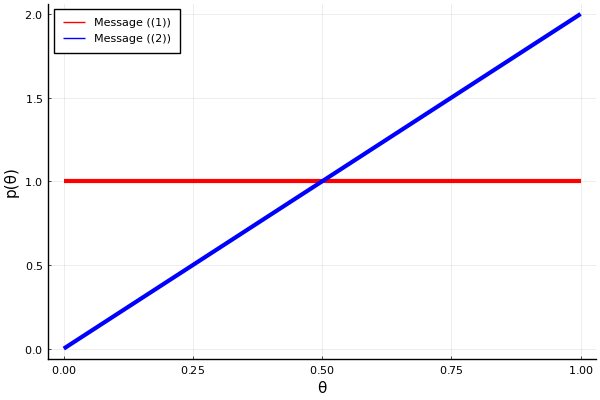

In [6]:
# Probability density function of a Beta distribution
Beta(θ, α, β) = 1/beta(α,β) * θ^(α-1) * (1-θ)^(β-1)

# Extract parameters from message ((1))
α1 = messages[1].dist.params[:a]
β1 = messages[1].dist.params[:b]

# Extract parameters from message ((2))
α2 = messages[2].dist.params[:a]
β2 = messages[2].dist.params[:b]

# Plot messages
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, Beta.(θ_range, α1, β1), color="red", linewidth=3, label="Message ((1))", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, Beta.(θ_range, α2, β2), color="blue", linewidth=3, label="Message ((2))")

The marginal distribution for $\theta$, representing the posterior $p(\theta \mid X_1)$, is obtained by taking the product (followed by normalization) of the two messages: $\overrightarrow{\mu}(\theta) \cdot \overleftarrow{\mu}(\theta)$. Multiplying two Beta distributions produces another Beta distribution with parameter:

$$\begin{align}
\alpha \leftarrow&\ \alpha_1 + \alpha_2 - 1 \\
\beta \leftarrow&\ \beta_1 + \beta_2 - 1 \, ,
\end{align}$$

In our case, the new parameters would be $\alpha = 1 + 2 - 1 = 2$ and $\beta = 1 + 1 - 1 = 1$. Let's check with ForneyLab what it computed.

In [7]:
marginals[:θ]

Beta(a=2.00, b=1.00)


Again, ForneyLab matches our manual derivations. Let's visualize the messages as well as the marginal.

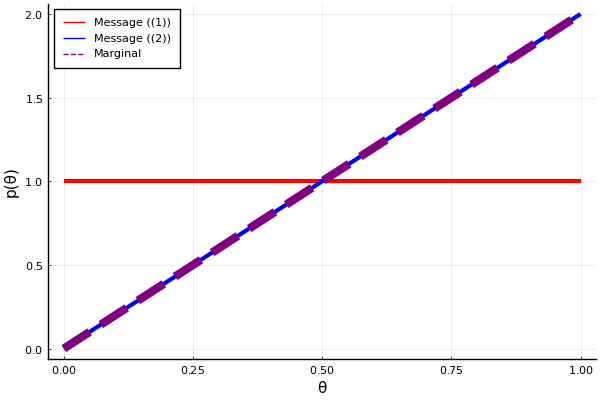

In [8]:
# Extract marginal's parameters
α_marg = marginals[:θ].params[:a]
β_marg = marginals[:θ].params[:b]

# Plot messages
θ_range = range(0, step=0.01, stop=1.0)
plot(θ_range, Beta.(θ_range, α1, β1), color="red", linewidth=3, label="Message ((1))", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, Beta.(θ_range, α2, β2), color="blue", linewidth=3, label="Message ((2))")
plot!(θ_range, Beta.(θ_range, α_marg, β_marg), color="purple", linewidth=6, linestyle=:dash, label="Marginal")

The pdf of the marginal distribution lies on top of the pdf of Message ((2)). That's not always going to be the case; the Beta(1,1) distribution is special in that when you multiply Beta(1,1) with a general Beta(a,b) the result will always be Beta(a,b), kinda like multiplying by $1$. We call prior distributions that have this special effect "non-informative priors".

#### Multiple questions

Of course, you won't be evaluated on just a single question: it's still possible for you to get one question wrong even if you have a high skill level. You would consider it unfair to be rejected based on only one question. So, we are going to add another question. We're also going to change the prior: the company now assumes that you must have _some_ skill if you applied for the position. This is reflected in a prior Beta distributions with $\alpha = 3.0$ and $\beta = 2.0$. 

For now, the second question is also a right-or-wrong question. The outcome of this new question is denoted with variable $X_2$. With this addition, the generative model becomes

$$p(X_1, X_2, \theta) = p(X_1 \mid \theta) p(X_2 \mid \theta) p(\theta) \, ,$$ 

with the accompanying factor graph

![](../figures/ffg-PP2-02.png)

where $f_c \triangleq \text{Bernoulli}(X_2 \mid \theta)$ and $f_a, f_b$ are still the same. Notice that we now have an equality node as well. That is because the variable $\theta$ is used in three factor nodes. ForneyLab automatically generates the same factor graph:

In [9]:
# Start building a model
factor_graph2 = FactorGraph()

# Add the prior
@RV θ ~ Beta(3.0, 2.0, id=:f_a)

# Add question 1 correctness likelihood
@RV X1 ~ Bernoulli(θ, id=:f_b)

# Add question 2 correctness likelihood
@RV X2 ~ Bernoulli(θ, id=:f_c)

# The question outcomes are going to be observed
placeholder(X1, :X1)
placeholder(X2, :X2)

# Visualize the graph
ForneyLab.draw(factor_graph2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10122357560011236815 -->
 
 10122357560011236815 
 
 Ber 
 f_b 
 
<!-- 4674971714906530689 -->
 
 4674971714906530689 
 
 placeholder_X1 
 
<!-- 4674971714906530689--10122357560011236815 -->
 
 4674971714906530689--10122357560011236815 
 
 X1 
 1 out 
 1 out 
 
<!-- 6126431897767028460 -->
 
 6126431897767028460 
 
 Beta 
 f_a 
 
<!-- 9500032239127013987 -->
 
 9500032239127013987 
 
 clamp_2 
 
<!-- 6126431897767028460--9500032239127013987 -->
 
 6126431897767028460--9500032239127013987 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 17082863549969332427 -->
 
 17082863549969332427 
 
 clamp_1 
 
<!-- 6126431897767028460--17082863549969332427 -->
 
 6126431897767028460--17082863549969332427 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 16158923832392652099 -->
 
 16158923832392652099 
 
 = 
 equ_θ_1 
 
<!-- 16158923832392652099--10122357560011236815 -->
 
 16158923832392652099--10122357560011236815 
 
 θ 
 2 p 
 2 2 
 
<!-- 16158923832392652099--6126431897767028460 -->
 
 16158923832392652099--6126431897767028460 
 
 θ 
 1 out 
 1 1 
 
<!-- 14888620920386558658 -->
 
 14888620920386558658 
 
 Ber 
 f_c 
 
<!-- 16158923832392652099--14888620920386558658 -->
 
 16158923832392652099--14888620920386558658 
 
 θ 
 2 p 
 3 3 
 
<!-- 4514135037956754383 -->
 
 4514135037956754383 
 
 placeholder_X2 
 
<!-- 4514135037956754383--14888620920386558658 -->
 
 4514135037956754383--14888620920386558658 
 
 X2 
 1 out 
 1 out

We will go through the message passing operations below. First, we generate an algorithm and visualize where all the messages for $\theta$ come from.

In [10]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10122357560011236815 -->
 
 10122357560011236815 
 
 Ber 
 f_b 
 
<!-- 6126431897767028460 -->
 
 6126431897767028460 
 
 Beta 
 f_a 
 
<!-- 9500032239127013987 -->
 
 9500032239127013987 
 
<!-- 6126431897767028460--9500032239127013987 -->
 
 6126431897767028460--9500032239127013987 
 
 1 out 
 3 b 
 
<!-- 17082863549969332427 -->
 
 17082863549969332427 
 
<!-- 6126431897767028460--17082863549969332427 -->
 
 6126431897767028460--17082863549969332427 
 
 1 out 
 2 a 
 
<!-- 16158923832392652099 -->
 
 16158923832392652099 
 
 = 
 equ_θ_1 
 
<!-- 16158923832392652099--10122357560011236815 -->
 
 16158923832392652099--10122357560011236815 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 16158923832392652099--6126431897767028460 -->
 
 16158923832392652099--6126431897767028460 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 14888620920386558658 -->
 
 14888620920386558658 
 
 Ber 
 f_c 
 
<!-- 16158923832392652099--14888620920386558658 -->
 
 16158923832392652099--14888620920386558658 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 4674971714906530689 -->
 
 4674971714906530689 
 
<!-- 4674971714906530689--10122357560011236815 -->
 
 4674971714906530689--10122357560011236815 
 
 1 out 
 1 out 
 
<!-- 4514135037956754383 -->
 
 4514135037956754383 
 
<!-- 4514135037956754383--14888620920386558658 -->
 
 4514135037956754383--14888620920386558658 
 
 1 out 
 1 out

There are 4 messages, one from the prior ((1)), one from the first likelihood ((2)), one from the second likelihood ((3)) and one from the equality node ((4)). ForneyLab essentially combines messages 2 and 3 into message 4 and then multiplies messages 1 and 4 to produce the marginal. We can see this if we look in the source code:

In [11]:
println(source_code)

begin

function stepθ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVBBetaOut(nothing, ProbabilityDistribution(Univariate, PointMass, m=3.0), ProbabilityDistribution(Univariate, PointMass, m=2.0))
messages[2] = ruleVBBernoulliIn1(ProbabilityDistribution(Univariate, PointMass, m=data[:X1]), nothing)
messages[3] = ruleVBBernoulliIn1(ProbabilityDistribution(Univariate, PointMass, m=data[:X2]), nothing)
messages[4] = ruleSPEqualityBeta(nothing, messages[2], messages[3])

marginals[:θ] = messages[1].dist * messages[4].dist

return marginals

end

end # block


You can see that `messages[4]` is a function of `messages[2]` and `messages[3]` and that `marginals[:θ]` is the product of `messages[1]` and `messages[4]`. 


Suppose you got the first question right and the second question wrong. Let's execute the message passing procedure and take a look at the functional form of the messages.

In [12]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, Beta, a=1.0, b=1.0))

# Suppose you got question 1 right and question 2 wrong
data = Dict(:X1 => 1,
            :X2 => 0)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
println("Message ((4)) = "*string(messages[4].dist))


Message ((1)) = Beta(a=3.00, b=2.00)
Message ((2)) = Beta(a=2.00, b=1.00)
Message ((3)) = Beta(a=1.00, b=2.00)
Message ((4)) = Beta(a=2.00, b=2.00)



Messages ((1)) and ((2)) are clear, but Message ((3)) and Message ((4)) are new. 

---

### $\ast$ **Try for yourself**

Try deriving the functional form of Message ((3)) for yourself. 
Tip: the derivation is very similar to that of Message ((2)). The most important change is to use $\delta(X_2 - 0)$ instead of $\delta(X_1 - 1)$.

---

Message ((4)) is the result of the standard message computation formula for the case of an equality node:

$$\begin{align}
\downarrow \mu(\theta) =&\ \sum_{\theta',\ \theta''} \overrightarrow{\mu}(\theta'')\ f_{=}(\theta, \theta', \theta'') \ \overleftarrow{\mu}(\theta') \\
 =&\ \overrightarrow{\mu}(\theta) \cdot \overleftarrow{\mu}(\theta) \\
=&\ \text{Beta}(\theta \mid 2, 1) \cdot \text{Beta}(\theta \mid 1, 2) \\
 =&\ \text{Beta}(\theta \mid 2, 2) \quad .
\end{align}$$

Let's visualize the messages and the marginal again.

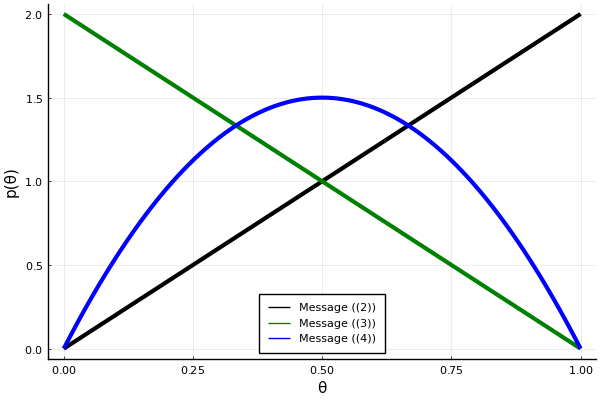

In [13]:
# Extract parameters from message ((2))
α2 = messages[2].dist.params[:a]
β2 = messages[2].dist.params[:b]

# Extract parameters from message ((3))
α3 = messages[3].dist.params[:a]
β3 = messages[3].dist.params[:b]

# Extract parameters from message ((4))
α4 = messages[4].dist.params[:a]
β4 = messages[4].dist.params[:b]

plot(θ_range, Beta.(θ_range, α2, β2), color="black", linewidth=3, label="Message ((2))")
plot!(θ_range, Beta.(θ_range, α3, β3), color="green", linewidth=3, label="Message ((3))")
plot!(θ_range, Beta.(θ_range, α4, β4), color="blue", linewidth=3, label="Message ((4))")
xlabel!("θ")
ylabel!("p(θ)")

Message ((2)) and Message ((3)) are direct opposites: ((2)) increases the estimate and ((3)) decreases the estimate of your skill level.  Message ((4)) end up being centered on $0.5$. With one question right and one question wrong, you have essentially been guessing at random.

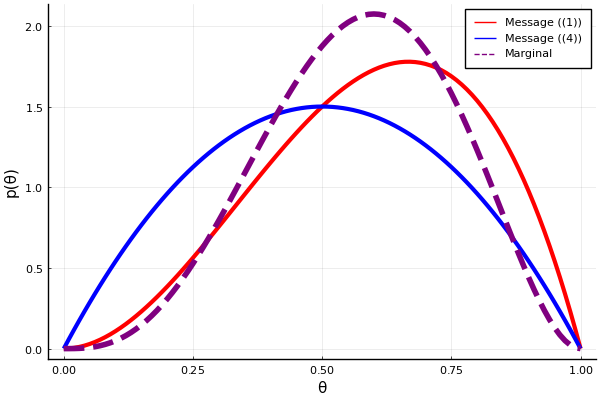

In [14]:
# Extract parameters from message ((1))
α1 = messages[1].dist.params[:a]
β1 = messages[1].dist.params[:b]

# Extract parameters from message ((4))
α4 = messages[4].dist.params[:a]
β4 = messages[4].dist.params[:b]

# Extract parameters
α_marg = marginals[:θ].params[:a]
β_marg = marginals[:θ].params[:b]

plot(θ_range, Beta.(θ_range, α1, β1), color="red", linewidth=3, label="Message ((1))")
plot!(θ_range, Beta.(θ_range, α4, β4), color="blue", linewidth=3, label="Message ((4))")
plot!(θ_range, Beta.(θ_range, α_marg, β_marg), color="purple", linewidth=4, linestyle=:dash, label="Marginal")
xlabel!("θ")
ylabel!("p(θ)")

If we now combine the prior (Message ((1)) in red above) with the combined message from both likelihood terms (Message ((4)) in blue), we get the new marginal (purple dotted line). The mean of the marginal lies above $0.5$, which is due to the prior assumption that you must have _some_ skill if you applied. 

### 2. Score questions

So far, the models we have been looking at have been quite simple; they are Beta-Bernoulli combinations which is exactly what we did for the Beer Tasting Experiment. We will now move on to more complicated distributions. These will enrich your toolbox and allow you to do much more.

Suppose you are not tested on a right-or-wrong question, but on a score question. For instance, you have to complete a piece of code for which you get a score. If all of it was wrong you get a score of $0$, if some of it was correct you get a score of $1$ and if all of it was correct you get a score $2$. That means we have a likelihood with three outcomes: $X_1 = \{ 0,1,2\}$. Suppose we once again ask two questions, $X_1$ and $X_2$. The order in which we ask these questions does not matter, so that means we choose Categorical distributions for these likelihood functions: $X_1, X_2 \sim \text{Categorical}(\theta)$. The parameter $\theta$ is no longer a single parameter, indicating the probability of getting the question right, but a vector of three parameters: $\theta = (\theta_1, \theta_2, \theta_3)$. Each $\theta_k$ indicates the probability of getting the $k$-th outcome. In other words, $\theta_1$ indicates the probability of getting $0$ points, $\theta_2$ of getting $1$ point and $\theta_3$ of getting two points. A highly-skilled applicant will have a parameter vector of $(0.05, 0.1, 0.85)$, for example. The prior distribution conjugate to the Categorical distribution is the Dirichlet distribution. 

Let's look at the generative model:

$$p(X_1, X_2, \theta) = p(X_1 \mid \theta) p(X_2 \mid \theta) p(\theta) \, .$$ 

It's the same as before. The only difference is that:

$$\begin{align}
p(X_1 \mid \theta) =&\ \text{Categorical}(X_1 \mid \theta) \\
p(X_2 \mid \theta) =&\ \text{Categorical}(X_2 \mid \theta) \\
p(\theta) =&\ \text{Dirichlet}(\theta)
\end{align}$$

The factor graph has the same structure as before. The only change is that the factor nodes $f_a, f_b, f_c$ are now parameterized differently. 

In [15]:
# Start building a model
factor_graph3 = FactorGraph()

# Add the prior
@RV θ ~ Dirichlet([1.0, 3.0, 2.0], id=:f_a)

# Add question 1 correctness likelihood
@RV X1 ~ Categorical(θ, id=:f_b)

# Add question 2 correctness likelihood
@RV X2 ~ Categorical(θ, id=:f_c)

# The question outcomes are going to be observed
placeholder(X1, dims=(3,), :X1)
placeholder(X2, dims=(3,), :X2)

# Visualize the graph
ForneyLab.draw(factor_graph3)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1173085875891538122 -->
 
 1173085875891538122 
 
 placeholder_X1 
 
<!-- 5658760734042102498 -->
 
 5658760734042102498 
 
 Cat 
 f_b 
 
<!-- 1173085875891538122--5658760734042102498 -->
 
 1173085875891538122--5658760734042102498 
 
 X1 
 1 out 
 1 out 
 
<!-- 10160759768783777875 -->
 
 10160759768783777875 
 
 Cat 
 f_c 
 
<!-- 5517863217488273843 -->
 
 5517863217488273843 
 
 clamp_1 
 
<!-- 1509893184691596635 -->
 
 1509893184691596635 
 
 = 
 equ_θ_1 
 
<!-- 1509893184691596635--10160759768783777875 -->
 
 1509893184691596635--10160759768783777875 
 
 θ 
 2 p 
 3 3 
 
<!-- 1509893184691596635--5658760734042102498 -->
 
 1509893184691596635--5658760734042102498 
 
 θ 
 2 p 
 2 2 
 
<!-- 449696707804689723 -->
 
 449696707804689723 
 
 Dir 
 f_a 
 
<!-- 1509893184691596635--449696707804689723 -->
 
 1509893184691596635--449696707804689723 
 
 θ 
 1 out 
 1 1 
 
<!-- 449696707804689723--5517863217488273843 -->
 
 449696707804689723--5517863217488273843 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 15053104750501260316 -->
 
 15053104750501260316 
 
 placeholder_X2 
 
<!-- 15053104750501260316--10160759768783777875 -->
 
 15053104750501260316--10160759768783777875 
 
 X2 
 1 out 
 1 out

The only difference with the previous graph is the fact that the node called "prior" is a 'Dir', short for Dirichlet, and that the two nodes called "likelihood1" and "likelihood2" are 'Cat' types, short for Categorical. Let's look at the message passing schedule:

In [16]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 10160759768783777875 -->
 
 10160759768783777875 
 
 Cat 
 f_c 
 
<!-- 1509893184691596635 -->
 
 1509893184691596635 
 
 = 
 equ_θ_1 
 
<!-- 1509893184691596635--10160759768783777875 -->
 
 1509893184691596635--10160759768783777875 
 
 θ 
 2 p 
 ((3)) 
 3 3 
 
<!-- 5658760734042102498 -->
 
 5658760734042102498 
 
 Cat 
 f_b 
 
<!-- 1509893184691596635--5658760734042102498 -->
 
 1509893184691596635--5658760734042102498 
 
 θ 
 2 p 
 ((2)) 
 2 2 
 
<!-- 449696707804689723 -->
 
 449696707804689723 
 
 Dir 
 f_a 
 
<!-- 1509893184691596635--449696707804689723 -->
 
 1509893184691596635--449696707804689723 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 5517863217488273843 -->
 
 5517863217488273843 
 
<!-- 449696707804689723--5517863217488273843 -->
 
 449696707804689723--5517863217488273843 
 
 1 out 
 2 a 
 
<!-- 1173085875891538122 -->
 
 1173085875891538122 
 
<!-- 1173085875891538122--5658760734042102498 -->
 
 1173085875891538122--5658760734042102498 
 
 1 out 
 1 out 
 
<!-- 15053104750501260316 -->
 
 15053104750501260316 
 
<!-- 15053104750501260316--10160759768783777875 -->
 
 15053104750501260316--10160759768783777875 
 
 1 out 
 1 out

That's the same as before as well: 2 messages from the likelihoods, 1 combined likelihood message from the equality node and 1 message from the prior.

If we now setup the message passing procedure, we have to be a little bit more careful. We cannot feed the scores $\{ 0,1,2\}$ as outcomes directly. We have to encode them in one-hot vectors (see Bert's lecture notes on discrete distributions). Suppose you had a score of $1$ for the first question and a score of $2$ for the second one. That translates into a vector $[0, 1, 0]$ and $[0, 0, 1]$, respectively. These we enter into the `data` dictionary:

In [17]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Dirichlet, a=[1.0, 1.0, 1.0]))

# Enter the observed outcomes in the placeholders
data = Dict(:X1 => [0, 1, 0],
            :X2 => [0, 0, 1])

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
print("Message ((4)) = "*string(messages[4].dist))
println("Marginal of θ = "*string(marginals[:θ]))


Message ((1)) = Dir(a=[1.00, 3.00, 2.00])
Message ((2)) = Dir(a=[1.00, 2.00, 1.00])
Message ((3)) = Dir(a=[1.00, 1.00, 2.00])
Message ((4)) = Dir(a=[1.00, 2.00, 2.00])
Marginal of θ = Dir(a=[1.00, 4.00, 3.00])



Visualizing a Dirichlet distribution is a bit tricky. In the special case of $3$ parameters, we can plot the probabilities on a simplex. As a reminder, a [simplex](https://en.wikipedia.org/wiki/Simplex) in 3-dimensions is the triangle between the coordinates $[0,0,1]$, $[0,1,0]$ and $[1,0,0]$:

<p style="text-align:center;"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/2D-simplex.svg/150px-2D-simplex.svg.png" width="150px"></p>

Each vector $\theta$ is a point on that triangle and its elements sum to $1$. Since the triangle is 2-dimensional, we can plot the Dirichlet's probability density over it.

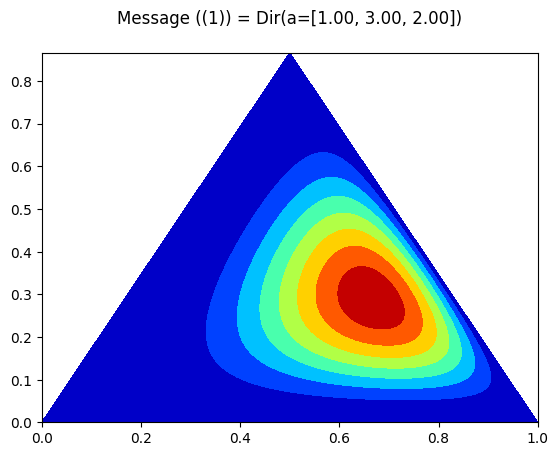

In [18]:
# Import matplotlib 
plt = pyimport("matplotlib.pyplot")

# Include helper function
include("../scripts/dirichlet_simplex.jl")

# Extract parameters of Message ((1))
α1 = messages[1].dist.params[:a]

# Compute pdf contour lines on the simplex
trimesh, pvals = pdf_contours_simplex(α1)

# Plot using matplotlib's tricontour
plt.tricontourf(trimesh, pvals, nlevels=200, cmap="jet");
plt.title("Message ((1)) = "*string(messages[1].dist));

Code notes:
- `pyimport` allows you to import Python modules. 
- When you `include()` another julia file, it is as if you wrote it at that point in your script.
- `tricontourf` is a function from Matplolib, where you create a contour plot over a triangulated mesh (here, the simplex).

----

The red spot is the area of high probability, with the contours around indicating increasing uncertainty. The prior, with concentration parameters $[1, 3, 2]$, reflects the belief that applicants are least likely to get the question completely wrong ($\alpha_1$ = 1, score = 0), most likely to get the question partly right ($\alpha_2$ = 3, score = 1) and moderately likely to get the question completely correct ($\alpha_3$ = 2, score = 2).

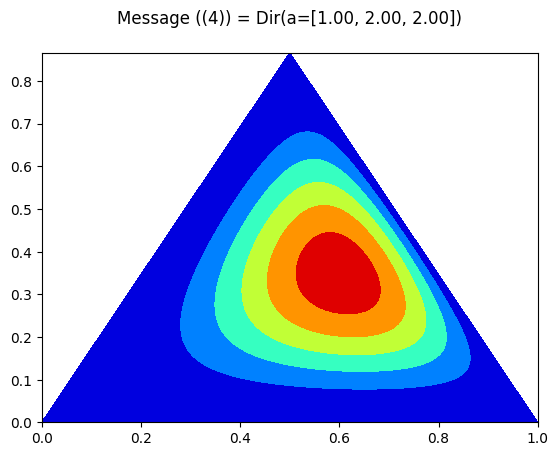

In [19]:
# Extract parameters 
α4 = messages[4].dist.params[:a]

# Compute pdf contour lines on the simplex
trimesh, pvals = pdf_contours_simplex(α4)

# Plot using matplotlib's tricontour
plt.tricontourf(trimesh, pvals, nlevels=200, cmap="jet")
plt.title("Message ((4)) = "*string(messages[4].dist));

Since we got scores $X_1 = 1$ and $X_2 = 2$, the combined message from both likelihoods has concentration parameters $[1,2,2]$. 

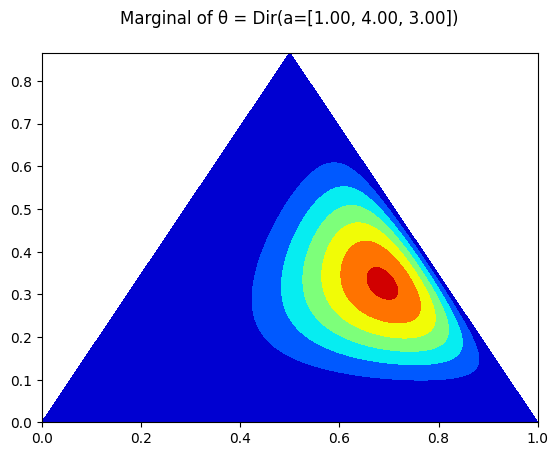

In [20]:
# Extract parameters 
α_marg = marginals[:θ].params[:a]

# Compute pdf contour lines on the simplex
trimesh, pvals = pdf_contours_simplex(α_marg)

# Plot using matplotlib's tricontour
plt.tricontourf(trimesh, pvals, nlevels=200, cmap="jet")
plt.title("Marginal of θ = "*string(marginals[:θ]));

The posterior is the combination of Messages ((1)) and ((4)) and focuses much more strongly in the area where the two messages overlap.

---

### $\ast$ **Try for yourself**

Play around with the prior parameters and your responses to the questions. See how they change your posterior.

---

### 3. Rating scale

You might want to evaluate someone by an even finer metric. For example, in oral exams you need to provide a score based on a conversation which is hard to quantify. You could do this by taking away the discrete set of responses and replacing it with a continuous response variable. For example, rating scales are forms of continuous response models. You would mark the applicant's performance on a question as a cross on a line:

<p style="text-align:center;"><img src="https://images.slideplayer.com/15/4506022/slides/slide_19.jpg" width="400px"></p>

It is still the case that there is some underlying level of skill, that we'll call $\theta$, and that the performance on each question is a noisy measurement of that skill, that we'll call $X$. We argue that performance noise is symmetric: the probability of performing a little better than their skill level is equal to performing a little worse. We will therefore use Gaussian, or Normal, likelihood functions: $p(X \mid \theta) = \text{Normal}(X \mid \theta, \sigma^2)$. The performance noise level will be fixed at $\sigma^2 = 5$, for now. The conjugate prior to the mean in Gaussian likelihoods is another Gaussian distribution: $p(\theta) = \text{Normal}(\theta \mid 50, 20)$. Say that we rate performance on a scale from $0$ to $100$, then it makes sense to use a mean of $60$ and a variance of $20$ for the prior.

We'll keep the same generative model as before, with new definitions for each distribution:

$$\begin{align}
p(X_1 \mid \theta) =&\ \text{Normal}(X_1 \mid \theta, 5) \\
p(X_2 \mid \theta) =&\ \text{Normal}(X_2 \mid \theta, 5) \\
p(\theta) =&\ \text{Normal}(\theta \mid 50, 20)
\end{align}$$

The factor graph will again be the same, but with different parameterizations of factor nodes:

In [21]:
# Start building a model
factor_graph4 = FactorGraph()

# Add the prior
@RV θ ~ GaussianMeanVariance(60, 20, id=:f_a)

# Add question 1 correctness likelihood
@RV X1 ~ GaussianMeanVariance(θ, 10, id=:f_b)

# Add question 2 correctness likelihood
@RV X2 ~ GaussianMeanVariance(θ, 10, id=:f_c)

# The question outcomes are going to be observed
placeholder(X1, :X1)
placeholder(X2, :X2)

# Visualize the graph
ForneyLab.draw(factor_graph4)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8223096583703210111 -->
 
 8223096583703210111 
 
 𝒩 
 f_b 
 
<!-- 8349399352490438436 -->
 
 8349399352490438436 
 
 clamp_3 
 
<!-- 8223096583703210111--8349399352490438436 -->
 
 8223096583703210111--8349399352490438436 
 
 clamp_3 
 1 out 
 3 v 
 
<!-- 12500164319608478541 -->
 
 12500164319608478541 
 
 clamp_4 
 
<!-- 3922634330060350522 -->
 
 3922634330060350522 
 
 clamp_1 
 
<!-- 5174299257499868032 -->
 
 5174299257499868032 
 
 = 
 equ_θ_1 
 
<!-- 5174299257499868032--8223096583703210111 -->
 
 5174299257499868032--8223096583703210111 
 
 θ 
 2 m 
 2 2 
 
<!-- 7758250879335785578 -->
 
 7758250879335785578 
 
 𝒩 
 f_a 
 
<!-- 5174299257499868032--7758250879335785578 -->
 
 5174299257499868032--7758250879335785578 
 
 θ 
 1 out 
 1 1 
 
<!-- 16571791039899164629 -->
 
 16571791039899164629 
 
 𝒩 
 f_c 
 
<!-- 5174299257499868032--16571791039899164629 -->
 
 5174299257499868032--16571791039899164629 
 
 θ 
 2 m 
 3 3 
 
<!-- 1054657465697269076 -->
 
 1054657465697269076 
 
 placeholder_X1 
 
<!-- 1054657465697269076--8223096583703210111 -->
 
 1054657465697269076--8223096583703210111 
 
 X1 
 1 out 
 1 out 
 
<!-- 7758250879335785578--3922634330060350522 -->
 
 7758250879335785578--3922634330060350522 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 1450637058843508975 -->
 
 1450637058843508975 
 
 clamp_2 
 
<!-- 7758250879335785578--1450637058843508975 -->
 
 7758250879335785578--1450637058843508975 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 14630569260928735212 -->
 
 14630569260928735212 
 
 placeholder_X2 
 
<!-- 14630569260928735212--16571791039899164629 -->
 
 14630569260928735212--16571791039899164629 
 
 X2 
 1 out 
 1 out 
 
<!-- 16571791039899164629--12500164319608478541 -->
 
 16571791039899164629--12500164319608478541 
 
 clamp_4 
 1 out 
 3 v

In [22]:
# Indicate which variables you want posteriors for
q = PosteriorFactorization(θ, ids=[:θ])

# Generate a message passing inference algorithm
algorithm = messagePassingAlgorithm(θ, q)

# Compile algorithm code
source_code = algorithmSourceCode(algorithm)

# Bring compiled code into current scope
eval(Meta.parse(source_code))

# Visualize message passing schedule
pfθ = q.posterior_factors[:θ]
ForneyLab.draw(pfθ, schedule=pfθ.schedule);

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.44.1 (0)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8223096583703210111 -->
 
 8223096583703210111 
 
 𝒩 
 f_b 
 
<!-- 8349399352490438436 -->
 
 8349399352490438436 
 
<!-- 8223096583703210111--8349399352490438436 -->
 
 8223096583703210111--8349399352490438436 
 
 1 out 
 3 v 
 
<!-- 5174299257499868032 -->
 
 5174299257499868032 
 
 = 
 equ_θ_1 
 
<!-- 5174299257499868032--8223096583703210111 -->
 
 5174299257499868032--8223096583703210111 
 
 θ 
 2 m 
 ((2)) 
 2 2 
 
<!-- 7758250879335785578 -->
 
 7758250879335785578 
 
 𝒩 
 f_a 
 
<!-- 5174299257499868032--7758250879335785578 -->
 
 5174299257499868032--7758250879335785578 
 
 θ 
 1 out 
 ((1)) 
 1 1 
 (4) 
 
<!-- 16571791039899164629 -->
 
 16571791039899164629 
 
 𝒩 
 f_c 
 
<!-- 5174299257499868032--16571791039899164629 -->
 
 5174299257499868032--16571791039899164629 
 
 θ 
 2 m 
 ((3)) 
 3 3 
 
<!-- 3922634330060350522 -->
 
 3922634330060350522 
 
<!-- 7758250879335785578--3922634330060350522 -->
 
 7758250879335785578--3922634330060350522 
 
 1 out 
 2 m 
 
<!-- 1450637058843508975 -->
 
 1450637058843508975 
 
<!-- 7758250879335785578--1450637058843508975 -->
 
 7758250879335785578--1450637058843508975 
 
 1 out 
 3 v 
 
<!-- 12500164319608478541 -->
 
 12500164319608478541 
 
<!-- 16571791039899164629--12500164319608478541 -->
 
 16571791039899164629--12500164319608478541 
 
 1 out 
 3 v 
 
<!-- 1054657465697269076 -->
 
 1054657465697269076 
 
<!-- 1054657465697269076--8223096583703210111 -->
 
 1054657465697269076--8223096583703210111 
 
 1 out 
 1 out 
 
<!-- 14630569260928735212 -->
 
 14630569260928735212 
 
<!-- 14630569260928735212--16571791039899164629 -->
 
 14630569260928735212--16571791039899164629 
 
 1 out 
 1 out

The message passing schedule is still exactly the same.

In [23]:
# Initialize a message data structure
messages = Array{Message}(undef, 4)

# Initalize marginal distributions data structure
marginals = Dict(:θ => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0.0, v=1.0))

# Enter the scores in the data dictionary
data = Dict(:X1 => 61.5,
            :X2 => 72)

# Update coefficients
stepθ!(data, marginals, messages);

# Print messages
print("\nMessage ((1)) = "*string(messages[1].dist))
print("Message ((2)) = "*string(messages[2].dist))
print("Message ((3)) = "*string(messages[3].dist))
print("Message ((4)) = "*string(messages[4].dist))
print("Marginal of θ = "*string(marginals[:θ]))


Message ((1)) = 𝒩(m=60, v=20)
Message ((2)) = 𝒩(m=61.50, v=10)
Message ((3)) = 𝒩(m=72, v=10)
Message ((4)) = 𝒩(xi=13.35, w=0.20)
Marginal of θ = 𝒩(m=65.40, v=4.00)


Message ((4)) has a somewhat unusual form in that uses `xi` as a parameter instead of `m`. When you take the product of Messages ((2)) and ((3)), the resulting mean is the sum of the precision-weighted means of Messages ((2)) and ((3)), normalized by the total precision (see [Bert's lecture](http://nbviewer.ipython.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/The-Gaussian-Distribution.ipynb)). `xi` represents the sum of precision-weighted means of the two messages.

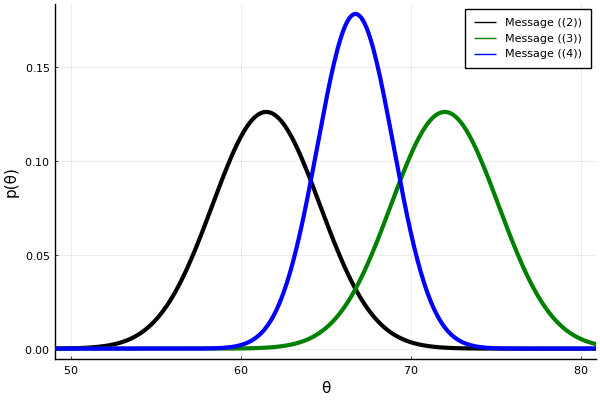

In [24]:
# Define probability density function for Gaussian distribution
pdf_Normal(θ, m, v) = 1/sqrt(2*π*v) * exp( -(θ - m)^2/(2*v))

# Extract parameters from message ((2))
m2 = messages[2].dist.params[:m]
v2 = messages[2].dist.params[:v]

# Extract parameters from message ((3))
m3 = messages[3].dist.params[:m]
v3 = messages[3].dist.params[:v]

# Extract parameters from message ((4))
m4 = mean(messages[4].dist)
v4 = var(messages[4].dist)

# Define new range for skill level θ
θ_range = range(0.0, step=0.1, stop=100.0)
plot(θ_range, pdf_Normal.(θ_range, m2, v2), color="black", linewidth=3, label="Message ((2))", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, pdf_Normal.(θ_range, m3, v3), color="green", linewidth=3, label="Message ((3))")
plot!(θ_range, pdf_Normal.(θ_range, m4, v4), color="blue", linewidth=3, label="Message ((4))", xlims=[50., 80.])

Message ((4)) is really a weighted average of Messages ((2)) and ((3)).

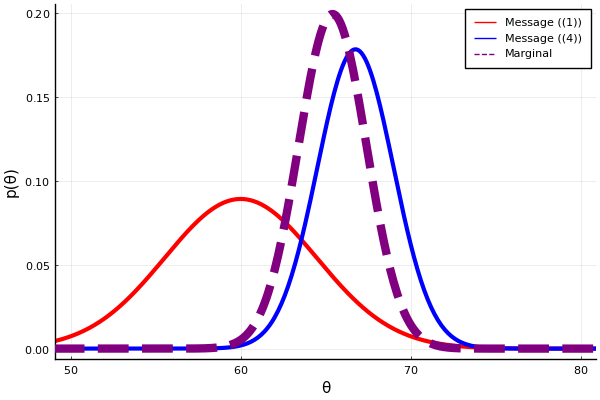

In [25]:
# Extract parameters from message ((1))
m1 = messages[1].dist.params[:m]
v1 = messages[1].dist.params[:v]

# Extract parameters from message ((4))
m4 = mean(messages[4].dist)
v4 = var(messages[4].dist)

# Extract parameters from marginal
m_marg = marginals[:θ].params[:m]
v_marg = marginals[:θ].params[:v]

# Define new range for skill level θ
plot(θ_range, pdf_Normal.(θ_range, m1, v1), color="red", linewidth=3, label="Message ((1))", xlabel="θ", ylabel="p(θ)")
plot!(θ_range, pdf_Normal.(θ_range, m4, v4), color="blue", linewidth=3, label="Message ((4))")
plot!(θ_range, pdf_Normal.(θ_range, m_marg, v_marg), color="purple", linewidth=6, linestyle=:dash, label="Marginal", xlims=[50., 80.])

The posterior is also a weighted average of two incoming messages. Notice that it is much closer to Message ((4)) than Message ((1)). That is because the variance of Message ((1)) (the prior) is much higher than that of Message ((4)) (the combination of likelihoods). The prior has a smaller weight in the weighted average.

---

### $\ast$ **Try for yourself**

Play around with different values for the prior's variance and the variance of the likelihoods. What happens when you make the variance of $p(X_1 \mid \theta)$ different from that of $p(X_2 \mid \theta)$?

---